# Health Insurance Cross Sell prediction

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

from scipy import stats

from sklearn.model_selection import train_test_split

#Import (Z-Scaler) StandardScaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [2]:
#Read dataset from the local drive

df = pd.read_csv('Health Insurance Cross Sell Prediction.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df[['Driving_License', 'Previously_Insured', 'Response']] = df[['Driving_License', 'Previously_Insured', 'Response']].astype('object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  object 
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  object 
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 34.9+ MB


In [5]:
#Shape
df.shape

(381109, 12)

In [6]:
df_copy = df.copy(deep=True)

## Remove insignificant variable id

In [7]:
# Remove insignificant variable id
df.drop('id', axis=1, inplace=True)

In [8]:
df.head(1)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1


## Duplicate records 

In [9]:
#Remove duplicates
df.duplicated(keep='first').value_counts(normalize=True) * 100

#There are totally 0.07% of duplicate records

False    99.929417
True      0.070583
dtype: float64

In [10]:
df.duplicated(keep='first').value_counts()

False    380840
True        269
dtype: int64

In [11]:
#We are keeping the first duplicate record and delete the rest
df.drop_duplicates(keep='first', inplace=True)

In [12]:
df.shape

#Shape after removing duplicates

(380840, 11)

In [13]:
df.head(1)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1


## Outlier treatment

In [14]:
#As seen in eda, only Annual_Premium variable had significant number of outliers

q1 = df['Annual_Premium'].quantile(0.25)
q3 = df['Annual_Premium'].quantile(0.75)

iqr = q3-q1

ll = q1 - 1.5*iqr
ul = q3 + 1.5*iqr

df[(df['Annual_Premium']<ll)|(df['Annual_Premium']>ul)].shape

(10331, 11)

In [15]:
#There are 10331 outliers

10331/len(df_copy) * 100

#2.71% outliers

2.7107730334366287

In [16]:
#We treat the outlier by Power transforming the Annual_Premium feature

print('Skewness of Annual_premium variable before Power transformation :', df['Annual_Premium'].skew())

df['Annual_Premium'] = pt.fit_transform(df[['Annual_Premium']])

print('\nSkewness of Annual_premium variable after Power transformation :', df['Annual_Premium'].skew())

Skewness of Annual_premium variable before Power transformation : 1.7699758877598497

Skewness of Annual_premium variable after Power transformation : 0.08644874083867982


In [17]:
#Skewness is reduced after applying Power transformation

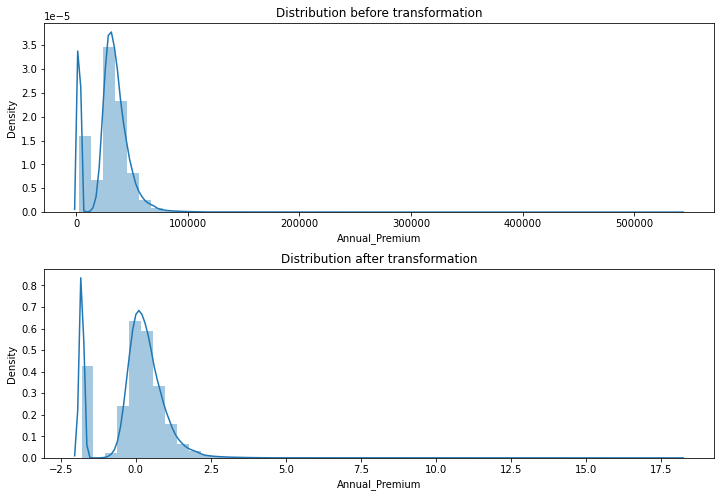

In [18]:
#distribution plot
plt.figure(figsize=(12,8))

plt.subplots_adjust(hspace=0.3)

plt.subplot(2,1,1)
sns.distplot(df_copy['Annual_Premium'])
plt.title('Distribution before transformation')

plt.subplot(2,1,2)
sns.distplot(df['Annual_Premium'])
plt.title('Distribution after transformation')

plt.show()

# Statistical Analysis for feature important

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380840 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                380840 non-null  object 
 1   Age                   380840 non-null  int64  
 2   Driving_License       380840 non-null  object 
 3   Region_Code           380840 non-null  float64
 4   Previously_Insured    380840 non-null  object 
 5   Vehicle_Age           380840 non-null  object 
 6   Vehicle_Damage        380840 non-null  object 
 7   Annual_Premium        380840 non-null  float64
 8   Policy_Sales_Channel  380840 non-null  float64
 9   Vintage               380840 non-null  int64  
 10  Response              380840 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 34.9+ MB


In [20]:
#Dividing the dataset to customers whose Response = 1 as res_1 and customers whose Response = 0 as res_0

#Customer who have not responded
res_0 = df[df['Response']==0]

#Customer who have responded
res_1 = df[df['Response']==1]

## Statistical analysis for Numerical columns

In [21]:
#Features whose datatype is 'numeric'
num_cols = list(df.select_dtypes(include='number'))

num_cols

['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

#### Test of Normality for numerical data (Shapiro test)

In [22]:
# Test of normality
# Ho: skew=0 (normal)
# Ha : skew !=0(not normal)

#Shapiro test

for col in num_cols:
    print(f'\nShapiro test for {col} feature :')
    print('Response = 0 :',stats.shapiro(res_0[col]))
    print('Response = 1 :',stats.shapiro(res_1[col]))


Shapiro test for Age feature :
Response = 0 : ShapiroResult(statistic=0.8927069902420044, pvalue=0.0)
Response = 1 : ShapiroResult(statistic=0.98533034324646, pvalue=0.0)

Shapiro test for Region_Code feature :
Response = 0 : ShapiroResult(statistic=0.942943811416626, pvalue=0.0)
Response = 1 : ShapiroResult(statistic=0.910094678401947, pvalue=0.0)

Shapiro test for Annual_Premium feature :
Response = 0 : ShapiroResult(statistic=0.8867270946502686, pvalue=0.0)
Response = 1 : ShapiroResult(statistic=0.8773977756500244, pvalue=0.0)

Shapiro test for Policy_Sales_Channel feature :
Response = 0 : ShapiroResult(statistic=0.7037640810012817, pvalue=0.0)
Response = 1 : ShapiroResult(statistic=0.7760171294212341, pvalue=0.0)

Shapiro test for Vintage feature :
Response = 0 : ShapiroResult(statistic=0.9550694823265076, pvalue=0.0)
Response = 1 : ShapiroResult(statistic=0.9550324082374573, pvalue=0.0)


For all the numerical features<br>
>pval = 0<br>
sig lvl = 0.05<br>
pval < sig lvl<br>
We reject Null hypothesis<br>
None of the Data is not normally distributed

#### Test for equality of variances (levene test)

In [23]:
#equality of variances
# Ho: Variance is equal
# Ha : Variance is not equal

for col in num_cols:
    print(f'\nLevene test for {col} feature :')
    print(stats.levene(res_0[col], res_1[col]))


Levene test for Age feature :
LeveneResult(statistic=6633.538628422177, pvalue=0.0)

Levene test for Region_Code feature :
LeveneResult(statistic=3053.0698944063884, pvalue=0.0)

Levene test for Annual_Premium feature :
LeveneResult(statistic=270.88947562916127, pvalue=7.62285405978932e-61)

Levene test for Policy_Sales_Channel feature :
LeveneResult(statistic=1240.365812496968, pvalue=2.8260034273411953e-271)

Levene test for Vintage feature :
LeveneResult(statistic=0.016631156245483985, pvalue=0.8973879117425655)


For features ==> 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel'
>   pval = 0<br>
    sig lvl = 0.05<br>
    pval < sig lvl<br>
    We reject Null hypothesis
 Population variances are not equal<br>

For 'Vintage' Feature :
>pval = 0.89<br>
sig lvl = 0.05<br>
pval > sig lvl<br>
We fail to reject Null hypothesis <br>
Population variances are equal

#### Mannwhitneyu (non-parametric ttest)

In [24]:
#As all the features are not normal, we cannot perform parametric test
#We will perform non-parametric test (Mannwhitneyu)

# Ho : mu1 = mu2(no relation)
# Ha : mu1 != mu (relation)

for col in num_cols:
    print(f'\nNon-parametric 2-sample Unpaired test for {col} feature and Response feature :')
    print(stats.mannwhitneyu(res_0[col], res_1[col]))


Non-parametric 2-sample Unpaired test for Age feature and Response feature :
MannwhitneyuResult(statistic=5819466844.5, pvalue=0.0)

Non-parametric 2-sample Unpaired test for Region_Code feature and Response feature :
MannwhitneyuResult(statistic=7783182369.0, pvalue=0.22206521509389776)

Non-parametric 2-sample Unpaired test for Annual_Premium feature and Response feature :
MannwhitneyuResult(statistic=7335224512.5, pvalue=1.159971779844667e-97)

Non-parametric 2-sample Unpaired test for Policy_Sales_Channel feature and Response feature :
MannwhitneyuResult(statistic=5974542861.5, pvalue=0.0)

Non-parametric 2-sample Unpaired test for Vintage feature and Response feature :
MannwhitneyuResult(statistic=7785774085.0, pvalue=0.2611062858219003)


For features :  'Age', 'Annual_Premium', 'Policy_Sales_Channel'<br>
>pval = 0<br>
sig lvl = 0.05<br>
pval < sig lvl<br>
We reject Null hypothesis
###### There is a relation between ('Age', 'Annual_Premium', 'Policy_Sales_Channel) and 'Response'

For features : 'Region_Code', 'Vintage'
>pval = 0.22, 0.26 (Region_Code and Vintage respectively)<br>
sig lvl = 0.05<br>
pval > sig lvl<br>
We fail to reject Null hypothesis<br>
######  'There is a no relation between (Region_code, Vintage) and Response'

## Statistical analysis for Categorical columns

In [25]:
#Chi-Square Test for Independence : It is a non-parametric test (hence no assumptions)
#H0 : The variables are independent
#H1 : The variables are not independent (i.e. variables are dependent)

In [26]:
#List of categorical features
cat_cols = list(df.select_dtypes(exclude='number'))

#Remove the target feature from the list
cat_cols.remove('Response')

cat_cols

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']

In [27]:
#perform chi2_contingency for all the categorical features and Response target
for col in cat_cols:
    print(f'{col} vs Response :')
    obs = pd.crosstab(index=df['Response'], columns=df[col]) #create a cross-tab for feature and target
    print('Observed values :\n',obs )
    print(stats.chi2_contingency(obs))
    print('Pvalue =',stats.chi2_contingency(obs)[1] )
    print('\n\n')

Gender vs Response :
Observed values :
 Gender    Female    Male
Response                
0         156728  177427
1          18174   28511
(1048.4156547001373, 5.3788975019355325e-230, 1, array([[153461.76297133, 180693.23702867],
       [ 21440.23702867,  25244.76297133]]))
Pvalue = 5.3788975019355325e-230



Driving_License vs Response :
Observed values :
 Driving_License    0       1
Response                    
0                771  333384
1                 41   46644
(38.651130265524095, 5.067390495010783e-10, 1, array([[7.12461559e+02, 3.33442538e+05],
       [9.95384413e+01, 4.65854616e+04]]))
Pvalue = 5.067390495010783e-10



Previously_Insured vs Response :
Observed values :
 Previously_Insured       0       1
Response                          
0                   159809  174346
1                    46527     158
(44334.57616237847, 0.0, 1, array([[181042.4484823, 153112.5515177],
       [ 25293.5515177,  21391.4484823]]))
Pvalue = 0.0



Vehicle_Age vs Response :
Observed va

For features : 'Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage'
>pval = 0<br>
sig lvl = 0.05<br>
pval < sig lvl<br>
We reject Null hypothesis<br>

There is relationship between these ('Gender',  'Driving_License',  'Previously_Insured', 'Vehicle_Age',  'Vehicle_Damage') and 'RESPONSE' variable<br>
##### Response (target variable) is dependent on all the categorical variable.

In [28]:
#Except Region_Code and Vintage, Response is dependent on all other variables

## Label encoding / One hot encoding

In [29]:
df.head(1)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,0.611367,26.0,217,1


In [30]:
#Driving_License, Previously_Insured, Response are already encoded but Data-type is object
#Change the datatype to int

In [31]:
df[['Driving_License', 'Previously_Insured', 'Response']] = df[['Driving_License', 'Previously_Insured', 'Response']].astype('int')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380840 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                380840 non-null  object 
 1   Age                   380840 non-null  int64  
 2   Driving_License       380840 non-null  int32  
 3   Region_Code           380840 non-null  float64
 4   Previously_Insured    380840 non-null  int32  
 5   Vehicle_Age           380840 non-null  object 
 6   Vehicle_Damage        380840 non-null  object 
 7   Annual_Premium        380840 non-null  float64
 8   Policy_Sales_Channel  380840 non-null  float64
 9   Vintage               380840 non-null  int64  
 10  Response              380840 non-null  int32  
dtypes: float64(3), int32(3), int64(2), object(3)
memory usage: 30.5+ MB


In [33]:
#One hot encoding the rest of categorical variables, by droping the first column after encoding

cat_cols = list(df.select_dtypes(exclude='number'))

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head(1)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,0.611367,26.0,217,1,1,0,1,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380840 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Age                    380840 non-null  int64  
 1   Driving_License        380840 non-null  int32  
 2   Region_Code            380840 non-null  float64
 3   Previously_Insured     380840 non-null  int32  
 4   Annual_Premium         380840 non-null  float64
 5   Policy_Sales_Channel   380840 non-null  float64
 6   Vintage                380840 non-null  int64  
 7   Response               380840 non-null  int32  
 8   Gender_Male            380840 non-null  uint8  
 9   Vehicle_Age_< 1 Year   380840 non-null  uint8  
 10  Vehicle_Age_> 2 Years  380840 non-null  uint8  
 11  Vehicle_Damage_Yes     380840 non-null  uint8  
dtypes: float64(3), int32(3), int64(2), uint8(4)
memory usage: 23.2 MB


In [35]:
df.shape

(380840, 12)

## Train-Test split

In [36]:
# X y split
y = df['Response']
X = df.drop('Response', axis=1)

In [37]:
#Train & test split with 0.3%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4)

print('X train Shape :',X_train.shape)
print('X test Shape :',X_test.shape)


X train Shape : (266588, 11)
X test Shape : (114252, 11)


### Model evaluation metrics

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

In [39]:
result_df = pd.DataFrame(columns=['Model_Name', 'Accuracy_score_train', 'roc_auc_score_train','f1_score_train','precision_score_train', 
                                  'recall_score_train','Accuracy_score_test', 'roc_auc_score_test','f1_score_test', 'precision_score_test', 'recall_score_test'  ])

result_df

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test


In [40]:
#Defining a function to append metrics in dataframe

def model_score_card(algo,  name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    algo.fit(X_train, y_train)
    
    #train datset
    y_train_pred = algo.predict(X_train)
    y_train_proba = algo.predict_proba(X_train)[::, 1]
    
    #test datset
    y_test_pred = algo.predict(X_test)
    y_test_proba = algo.predict_proba(X_test)[::, 1]
    
    global result_df
    
    result_df = result_df.append({'Model_Name' : name,
                                    
                                    'Accuracy_score_train' :accuracy_score(y_train, y_train_pred) ,
                                    'roc_auc_score_train' : roc_auc_score(y_train, y_train_proba),
                                    'f1_score_train' : f1_score(y_train, y_train_pred), 
                                    'precision_score_train' : precision_score(y_train, y_train_pred), 
                                    'recall_score_train' : recall_score(y_train, y_train_pred),
                                    
                                    'Accuracy_score_test':accuracy_score(y_test, y_test_pred),
                                      'f1_score_test' :f1_score(y_test, y_test_pred) ,
                                    'roc_auc_score_test' : roc_auc_score(y_test, y_test_proba),
                                     
                                    'precision_score_test' : precision_score(y_test, y_test_pred), 
                                    'recall_score_test' : recall_score(y_test, y_test_pred)}, ignore_index = True)
    
    return result_df

In [41]:
#Defining a function to get evaluation metrics

def model_eval(algo,  X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    algo.fit(X_train, y_train)
    
    #train datset
    y_train_pred = algo.predict(X_train)
    y_train_proba = algo.predict_proba(X_train)[::, 1]

    print('Train dataset :')
    print('Confusion matrix :\n', confusion_matrix(y_train, y_train_pred))
    print('Accuracy :',accuracy_score(y_train, y_train_pred) )
    print('AUC score :', roc_auc_score(y_train, y_train_proba))
    print('F1-score :', f1_score(y_train, y_train_pred))
    print('Precision score :', precision_score(y_train, y_train_pred))
    print('Recall score :', recall_score(y_train, y_train_pred))
    
    #test datset
    y_test_pred = algo.predict(X_test)
    y_test_proba = algo.predict_proba(X_test)[::, 1]
    print('\n\nTest dataset :')
    print('Confusion matrix :\n', confusion_matrix(y_test, y_test_pred))
    print('Accuracy :',accuracy_score(y_test, y_test_pred) )
    print('AUC score :', roc_auc_score(y_test, y_test_proba))
    print('F1-score :', f1_score(y_test, y_test_pred))
    print('Precision score :', precision_score(y_test, y_test_pred))
    print('Recall score :', recall_score(y_test, y_test_pred))

# Model building

## 1.Logistic Regression as a base model

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
lor = LogisticRegression(solver='liblinear',random_state=4)

model_eval(lor)

Train dataset :
Confusion matrix :
 [[233965      4]
 [ 32618      1]]
Accuracy : 0.8776314012633727
AUC score : 0.8367805793300733
F1-score : 6.13045610593428e-05
Precision score : 0.2
Recall score : 3.06569790612833e-05


Test dataset :
Confusion matrix :
 [[100184      2]
 [ 14066      0]]
Accuracy : 0.8768686762594966
AUC score : 0.8366018357710197
F1-score : 0.0
Precision score : 0.0
Recall score : 0.0


In [44]:
## Appending the evaluation metrics in a DataFrame for further reference

lor = LogisticRegression(solver='liblinear',random_state=4)

model_score_card(lor, 'Logistic Regression')

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877631,0.836781,0.000061,0.2,0.000031,0.876869,0.836602,0.0,0.0,0.0


In [45]:
lor = LogisticRegression(solver='liblinear',random_state=4)
lor.fit(X_train, y_train)
    
    #train datset
y_train_pred = lor.predict(X_train)
y_train_proba = lor.predict_proba(X_train)[::, 1]
    
    #test datset
y_test_pred = lor.predict(X_test)
y_test_proba = lor.predict_proba(X_test)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_train_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('Logistic Regression Base model :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

NameError: name 'roc_curve' is not defined

## 2. Improving the base model (Logistic Regression):
>2.1 Data Transformation (Power transformation / Standard Scaler)<br>
2.2 Feature selection (Recursive Feature Elimination)<br>
2.3 SMOTE analysis

> ### 2.1 Data Transformation (Power transformation / Standard Scaler)

In [ ]:
#First we check for skewness & then transform the data to reduce the skewness 
#We are checking skewness for numerical columns & only for Train data and transform test data to avoid Data-leakage

X_train[num_cols].skew()

In [ ]:
#As Age feature is right skewed, we will use Power transformation to reduce the reduce

print('Skewness before transformation :', X_train['Age'].skew())

X_train['Age'] = pt.fit_transform(X_train[['Age']])
X_test['Age'] = pt.transform(X_test[['Age']])

print('\nSkewness after Power transformation :', X_train['Age'].skew())

In [ ]:
#Skewness of Region Code is -0.113, which is almost equal to 0
#So we will avoid transformation for Region_code feature

In [ ]:
#Policy_Sales_Channel is left skewed, so Power tranformation will not work properly
#So, after trail & error, (To the power of 6) gives best results

print('Skewness before transformation :', X_train['Policy_Sales_Channel'].skew())

X_train['Policy_Sales_Channel'] = X_train['Policy_Sales_Channel']**6
X_test['Policy_Sales_Channel'] = X_test['Policy_Sales_Channel']**6

print('\nSkewness after Power transformation :', X_train['Policy_Sales_Channel'].skew())

In [ ]:
#Scaling the whole data using StandardScaler
# Fit on Train data and tranform it on Test data to avoid Data-Leakage

X_train[num_cols] = ss.fit_transform(X_train[num_cols])

X_test[num_cols] = ss.transform(X_test[num_cols])

In [ ]:
#Building the Logistic regression on transformed data to check the improvement

lor = LogisticRegression(solver='liblinear',random_state=4)

model_eval(lor)

##### There is no change in base model after data transformation

In [ ]:
# X and Y dataset after transformation

In [ ]:
#concat train and test dataset for variable Y
y_full = pd.concat([y_train, y_test], axis=0)
y_full.shape

In [ ]:
#concat train and test dataset for variable X

X_full = pd.concat([X_train, X_test], axis=0)
X_full.shape

>### 2.2 Feature selection (Recursive Feature Elimination)

In [ ]:
from sklearn.feature_selection import RFE, RFECV

#estimator used is LogisticRegression
lor = LogisticRegression(solver='liblinear',random_state=4)

In [ ]:
#RUN RFECV to find out the best number of features to be selected
rfe_n = RFECV(estimator=lor, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
rfe_n.fit(X_full, y_full)

In [ ]:
#Number
print('Number of features selected :', rfe_n.n_features_)

#Selected features
selected = list(X_full.columns[rfe_n.support_])
print('\nSelected features :',selected)

In [ ]:
#selecting only features from RFE in both train & test dataset

X_train_sel = X_train[selected]
X_test_sel = X_test[selected]

In [ ]:
lor = LogisticRegression(solver='liblinear',random_state=4)

model_eval(lor, X_train_sel, X_test_sel, y_train, y_test)

##### There is no change in base model after Feature selection (RFE)

>### 2.3 SMOTE analysis

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='minority')

#SMOTE analysis on train dataset
X_train_sm, y_train_sm = smote.fit_resample(X_train_sel, y_train)

print('Shape of X train', X_train_sm.shape)

print('\nCount of target variable :')
print(y_train_sm.value_counts())

#after smote analysis, target variable is equally distributed

In [105]:
#building LogisticRegression on smote analysed data
lor = LogisticRegression(solver='liblinear',random_state=4)

#Model evaluation
model_eval(lor, X_train_sm,X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[139172  94797]
 [  6990 226979]]
Accuracy : 0.782477593185422
AUC score : 0.83404263738345
F1-score : 0.816845855563253
Precision score : 0.7053944358808613
Recall score : 0.9701242472293338


Test dataset :
Confusion matrix :
 [[59476 40710]
 [  383 13683]]
Accuracy : 0.640330147393481
AUC score : 0.834148755957173
F1-score : 0.3997429118158314
Precision score : 0.25155810490320446
Recall score : 0.9727712213848998


Even though there is huge change in Accuracy<br>
Recall, Precision and F1-score has been increased<br>
But the model is Over-fitting

In [113]:
## Appending the evaluation metrics in a DataFrame for further reference
##This is the final base model
model_score_card(lor, 'Logistic Regression Final base_model', X_train_sm,X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771


Logistic Regression Final-Base_model :


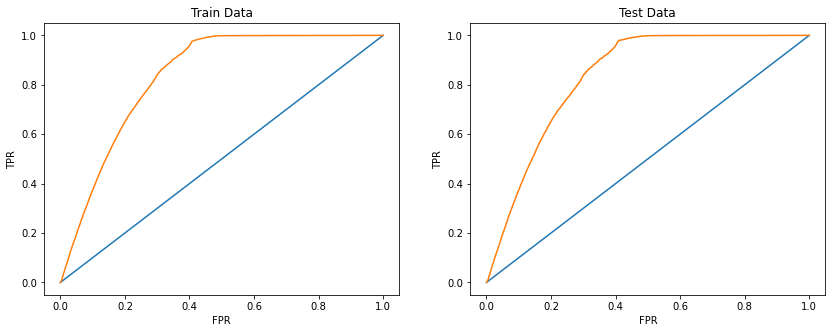

In [75]:
lor = LogisticRegression(solver='liblinear',random_state=4)
lor.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = lor.predict(X_train_sm)
y_train_sm_proba = lor.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = lor.predict(X_test_sel)
y_test_proba = lor.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('Logistic Regression Final-Base_model :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 3. Decision Tree Classifier
>  3.1 Decision Tree Classifier<br>
>  3.2 Decision Tree Classifier with Hyper-parameter tuning

>### 3.1 Decision Tree Classifier

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [119]:
#Build DTC model on Dataset which are : RFE selected features, smote analysed

dtc = DecisionTreeClassifier()

model_eval(dtc, X_train_sm,X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[223382  10587]
 [  2973 230996]]
Accuracy : 0.9710218020336028
AUC score : 0.9971058640725625
F1-score : 0.9714857681178926
Precision score : 0.9561765521580575
Recall score : 0.9872931884138497


Test dataset :
Confusion matrix :
 [[81895 18291]
 [ 6884  7182]]
Accuracy : 0.7796537478556174
AUC score : 0.6711210696377169
F1-score : 0.36328688130706394
Precision score : 0.28194558944765047
Recall score : 0.5105929190956917


>### 3.2 Decision Tree Classifier with Hyper-parameter tuning

In [77]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import randint as sp_randint

In [79]:
# GridSearchCV & RandomizedSearchCV results were almost similar
# We are considering RandomizedSearchCV for Hyper-parameter tuning

dtc = DecisionTreeClassifier(random_state=4)

params = {'max_depth' : sp_randint(2,10),
         'min_samples_leaf' : sp_randint(1,12),
         'criterion' : ['gini', 'entropy']}

rsearch = RandomizedSearchCV(dtc, param_distributions=params, n_iter=100, n_jobs=-1, 
                             cv=3, scoring='roc_auc', random_state=4)

# RandomizedSearchCV on overall transformed datasets
rsearch.fit(X_full,y_full)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=4),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000001950BB7E50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000194E8C2430>},
                   random_state=4, scoring='roc_auc')

In [123]:
#Best parameters
print(rsearch.best_params_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3}


In [124]:
dtc = DecisionTreeClassifier(**rsearch.best_params_, random_state=4)

model_eval(dtc, X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[157437  76532]
 [ 15583 218386]]
Accuracy : 0.8031469981065867
AUC score : 0.8628233728690978
F1-score : 0.8258323611659958
Precision score : 0.7404973585878108
Recall score : 0.933397159452748


Test dataset :
Confusion matrix :
 [[67218 32968]
 [ 1367 12699]]
Accuracy : 0.6994800966285054
AUC score : 0.8460278243337576
F1-score : 0.42519210486665665
Precision score : 0.2780782622024657
Recall score : 0.9028152993032845


##### Decision Tree Classifier after hyper-parameter tuning is giving better results. It is better fit model compared to previous model
##### Recall , Precision , F1-score, AUC score is increased compared to previous model.

In [129]:
## Appending the evaluation metrics in a DataFrame for further reference

dtc = DecisionTreeClassifier(**rsearch.best_params_, random_state=4)

model_score_card(dtc, 'DecisionTreeClassifier HyperParameter-tuning', X_train_sm,X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771
2,DecisionTreeClassifier HyperParameter-tuning,0.803147,0.862823,0.825832,0.740497,0.933397,0.699480,0.846028,0.425192,0.278078,0.902815


DecisionTreeClassifier HyperParameter-tuning :


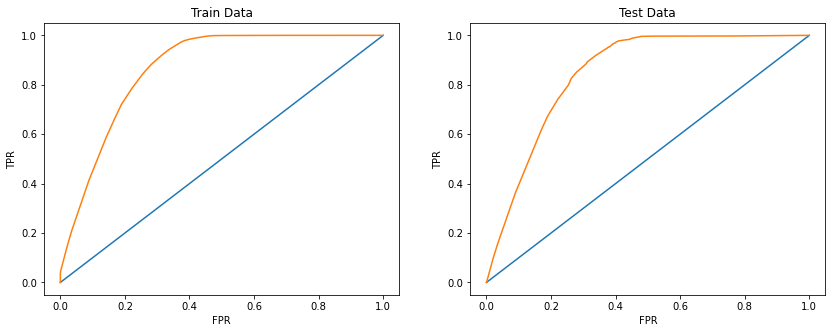

In [80]:
dtc = DecisionTreeClassifier(**rsearch.best_params_, random_state=4)
dtc.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = dtc.predict(X_train_sm)
y_train_sm_proba = dtc.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = dtc.predict(X_test_sel)
y_test_proba = dtc.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('DecisionTreeClassifier HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 4. Random forest Classifier
>  4.1 Random forest Classifier<br>
>  4.2 Random forest Classifier with Hyper-parameter tuning

>### 4.1 Random forest Classifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

#Build RFC model on Dataset which are : RFE selected features, smote analysed

In [131]:
rfc = RandomForestClassifier(random_state=4)

#model evaluation
model_eval(rfc, X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[219098  14871]
 [  2701 231268]]
Accuracy : 0.962448016617586
AUC score : 0.9935201548439186
F1-score : 0.9633999016887866
Precision score : 0.9395829185947777
Recall score : 0.9884557355889028


Test dataset :
Confusion matrix :
 [[81523 18663]
 [ 6528  7538]]
Accuracy : 0.7795137065434303
AUC score : 0.8078968525907091
F1-score : 0.374400874164949
Precision score : 0.2876989427884432
Recall score : 0.5359021754585526


>### 4.2 Random forest Classifier with Hyper-parameter tuning

In [132]:
# GridSearchCV & RandomizedSearchCV results were almost similar
# We are considering RandomizedSearchCV for Hyper-parameter tuning

In [82]:
%%time

rfc = RandomForestClassifier(random_state=4)

params = {'n_estimators': sp_randint(50,200),
         'max_features': sp_randint(1,15),
         'min_samples_leaf' : sp_randint(1,25),
          'max_depth' : sp_randint(1,10),
         'criterion' : ['gini', 'entropy']}

rsearch = RandomizedSearchCV(rfc, param_distributions=params, cv=3, n_iter=10,verbose=2, 
                             scoring='roc_auc', random_state=4, n_jobs=-1)
rsearch.fit(X_full, y_full)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Wall time: 8min 38s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=4),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000194E04E1F0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000194DEB6280>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000194E03EC70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000001950CF0670>},
                   random_state=4, scoring='roc_auc', verbose=2)

In [134]:
#Best parameters
print(rsearch.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'min_samples_leaf': 10, 'n_estimators': 108}


In [135]:
rfc = RandomForestClassifier(**rsearch.best_params_, random_state=4)

model_eval(rfc, X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[154041  79928]
 [ 13214 220755]]
Accuracy : 0.8009522629066244
AUC score : 0.8682660337079658
F1-score : 0.8257894854971084
Precision score : 0.7341785202355969
Recall score : 0.943522432459001


Test dataset :
Confusion matrix :
 [[65753 34433]
 [  928 13138]]
Accuracy : 0.6904999474845079
AUC score : 0.8523686508996864
F1-score : 0.42630238330872683
Precision score : 0.2761766622522125
Recall score : 0.9340253092563628


##### Random Forest Classifier after hyper-parameter tuning is giving better results. It is better fit model compared to previous model
##### Recall , F1-score, AUC score is increased compared to previous model.

In [136]:
## Appending the evaluation metrics in a DataFrame for further reference

rfc = RandomForestClassifier(**rsearch.best_params_, random_state=4)

model_score_card(rfc, 'RandomForestClassifier HyperParameter-tuning', X_train_sm,X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771
2,DecisionTreeClassifier HyperParameter-tuning,0.803147,0.862823,0.825832,0.740497,0.933397,0.699480,0.846028,0.425192,0.278078,0.902815
3,RandomForestClassifier HyperParameter-tuning,0.800952,0.868266,0.825789,0.734179,0.943522,0.690500,0.852369,0.426302,0.276177,0.934025


RandomForestClassifier HyperParameter-tuning :


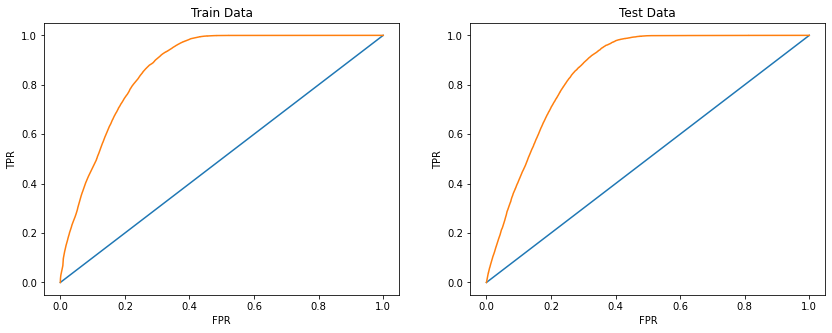

In [84]:
rfc = RandomForestClassifier(**rsearch.best_params_, random_state=4)
rfc.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = rfc.predict(X_train_sm)
y_train_sm_proba = rfc.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = rfc.predict(X_test_sel)
y_test_proba = rfc.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('RandomForestClassifier HyperParameter-tuning :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 5. LGBMClassifier
>  5.1 LGBMClassifier<br>
>  5.2 LGBMClassifier with Hyper-parameter tuning

>### 5.1 LGBMClassifier

In [87]:
import lightgbm as lgb

#Build RFC model on Dataset which are : RFE selected features, smote analysed

In [139]:
lgbc = lgb.LGBMClassifier()

#model evaluation
model_eval(lgbc, X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[170957  63012]
 [ 18277 215692]]
Accuracy : 0.8262825417042429
AUC score : 0.9058494926751107
F1-score : 0.8414408404577577
Precision score : 0.7739106722544348
Recall score : 0.9218828135351265


Test dataset :
Confusion matrix :
 [[73047 27139]
 [ 2424 11642]]
Accuracy : 0.7412474179883065
AUC score : 0.849105849739703
F1-score : 0.44059265426608896
Precision score : 0.30019855083674996
Recall score : 0.8276695577989478


>### 5.2 LGBMClassifier with Hyper-parameter tuning

In [142]:
from scipy.stats import uniform as sp_uniform

In [143]:
lgbc = lgb.LGBMClassifier()

params = {'n_estimators':sp_randint(50,250),
         'max_depth' : sp_randint(1,50),
         'learning_rate' : sp_uniform(0,0.5)}

rsearch = RandomizedSearchCV(lgbc, param_distributions=params, scoring='roc_auc', cv=3, n_iter=10,
                             n_jobs=-1, random_state=4)
rsearch.fit(X_full, y_full)

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000919DE7B100>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000919DE7CF10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000919EE093A0>},
                   random_state=4, scoring='roc_auc')

In [144]:
#Best parameters
print(rsearch.best_params_)

{'learning_rate': 0.30626266966227916, 'max_depth': 3, 'n_estimators': 224}


In [145]:
lgbc = lgb.LGBMClassifier(**rsearch.best_params_, random_state=4)

model_eval(lgbc,  X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[172196  61773]
 [ 18560 215409]]
Accuracy : 0.8283255474015788
AUC score : 0.9135424628284828
F1-score : 0.8428390045211689
Precision score : 0.777139208173691
Recall score : 0.9206732515846117


Test dataset :
Confusion matrix :
 [[73644 26542]
 [ 2503 11563]]
Accuracy : 0.7457812554703638
AUC score : 0.8482661950889928
F1-score : 0.4432730827471201
Precision score : 0.30345099068363734
Recall score : 0.8220531778757287


##### LGBMClassifier model results before and after hyper-parameter tuning is same, Model is slightly over-fit

In [146]:
## Appending the evaluation metrics in a DataFrame for further reference

lgbc = lgb.LGBMClassifier(random_state=4)

model_score_card(lgbc, 'LGBMClassifier', X_train_sm,X_test_sel, y_train_sm, y_test)

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771
2,DecisionTreeClassifier HyperParameter-tuning,0.803147,0.862823,0.825832,0.740497,0.933397,0.699480,0.846028,0.425192,0.278078,0.902815
3,RandomForestClassifier HyperParameter-tuning,0.800952,0.868266,0.825789,0.734179,0.943522,0.690500,0.852369,0.426302,0.276177,0.934025
4,LGBMClassifier,0.825996,0.905526,0.841440,0.772846,0.923396,0.739908,0.849445,0.440882,0.299780,0.832930


LGBMClassifier :


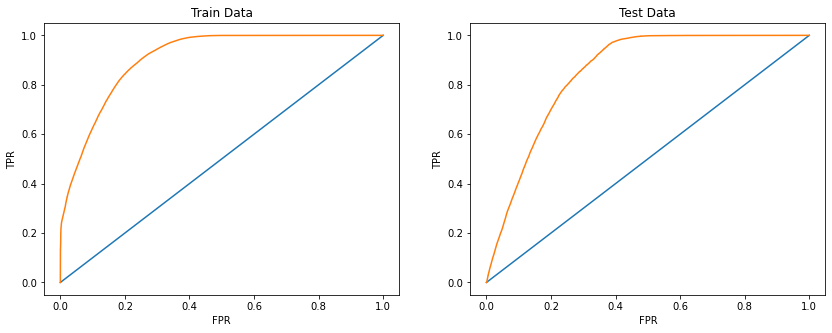

In [88]:
lgbc = lgb.LGBMClassifier(random_state=4)
lgbc.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = lgbc.predict(X_train_sm)
y_train_sm_proba = lgbc.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = lgbc.predict(X_test_sel)
y_test_proba = lgbc.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print('LGBMClassifier :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

## 6. Naive Bayes
>  6.1 GaussianNB<br>
>  6.2 GaussianNB SMOTE analysis<br>
>  6.3 GaussianNB Hyper-parameter Tuning<br>

In [89]:
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_curve

>###  6.1 GaussianNB<br>


In [152]:
#Model built on transformed data
nb = GaussianNB()

model_eval(nb, X_train_sel, X_test_sel, y_train, y_test)

Train dataset :
Confusion matrix :
 [[162528  71441]
 [  4082  28537]]
Accuracy : 0.7167051780275181
AUC score : 0.8170812425096133
F1-score : 0.4304320610571884
Precision score : 0.2854327952149473
Recall score : 0.8748582114718416


Test dataset :
Confusion matrix :
 [[69439 30747]
 [ 1768 12298]]
Accuracy : 0.7154097958897875
AUC score : 0.8179248168859496
F1-score : 0.43067009857995836
Precision score : 0.28570101057033337
Recall score : 0.8743068391866913


 GaussianNB :


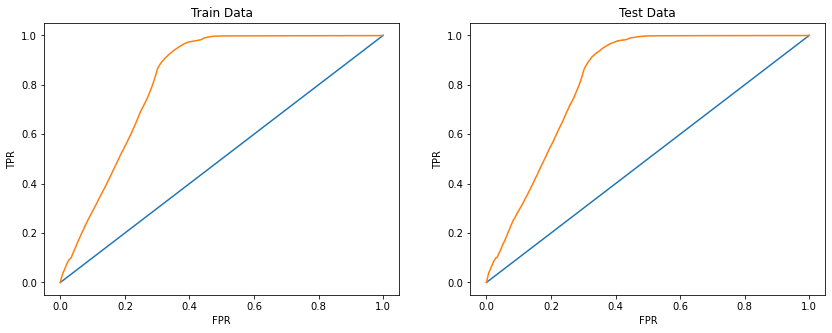

In [90]:
nb = GaussianNB()
nb.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = nb.predict(X_train_sm)
y_train_sm_proba = nb.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = nb.predict(X_test_sel)
y_test_proba = nb.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' GaussianNB :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

> ###  6.2 GaussianNB SMOTE analysis


In [153]:
nb = GaussianNB()

model_eval(nb, X_train_sm, X_test_sel, y_train_sm, y_test)

Train dataset :
Confusion matrix :
 [[142654  91315]
 [  7032 226937]]
Accuracy : 0.7898289944394343
AUC score : 0.8173339172695934
F1-score : 0.8219064468754357
Precision score : 0.7130732878347976
Recall score : 0.96994473626848


Test dataset :
Confusion matrix :
 [[60919 39267]
 [  415 13651]]
Accuracy : 0.6526800406119805
AUC score : 0.8180770270212235
F1-score : 0.4075898722082886
Precision score : 0.2579651536339242
Recall score : 0.9704962320489122


In [154]:
#Recall is increased but the model is over fitted, so we cant consider this model

> ### 6.3 GaussianNB Hyper-parameter Tuning

In [156]:
nb_classifier = GaussianNB()

#default var_smoothing is 1e-09
#We can try a range between 1e-0.15 to 1e-0.5

params_NB = {'var_smoothing': np.logspace(-5, -15, num=200)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=3,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_full, y_full)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e-05, 8.90735464e-06, 7.93409667e-06, 7.06718127e-06,
       6.29498899e-06, 5.60716994e-06, 4.99450512e-06, 4.44878283e-06,
       3.96268864e-06, 3.52970730e-06, 3.14403547e-06, 2.80050389e-06,
       2.49450814e-06, 2.22194686e-06, 1.97916687e-06, 1.76291412e-06,
       1.57029012e-06, 1.39871310e-06, 1.24...
       1.43145894e-14, 1.27505124e-14, 1.13573336e-14, 1.01163798e-14,
       9.01101825e-15, 8.02643352e-15, 7.14942899e-15, 6.36824994e-15,
       5.67242607e-15, 5.05263107e-15, 4.50055768e-15, 4.00880633e-15,
       3.57078596e-15, 3.18062569e-15, 2.83309610e-15, 2.52353917e-15,
       2.24780583e-15, 2.00220037e-15, 1.78343088e-15, 1.58856513e-15,
       1.41499130e-15, 1.26038293e-15, 1.12266777e-15, 1.00000000e-15])},
             scoring='accuracy', verbose=1)

In [157]:
#Best parameters
print(gs_NB.best_params_)

{'var_smoothing': 8.90735463861044e-06}


In [160]:
gnb = GaussianNB(**gs_NB.best_params_)

#As we got better result on GaussianNB for data without SMOTE analysis, we will use the same dataset
model_eval(gnb,  X_train_sel, X_test_sel, y_train, y_test)

Train dataset :
Confusion matrix :
 [[162548  71421]
 [  4093  28526]]
Accuracy : 0.7167389379867061
AUC score : 0.8170811358511204
F1-score : 0.4303667607078738
Precision score : 0.28541126797202515
Recall score : 0.8745209847021674


Test dataset :
Confusion matrix :
 [[69445 30741]
 [ 1771 12295]]
Accuracy : 0.7154360536358225
AUC score : 0.8179247672129499
F1-score : 0.43063290252530556
Precision score : 0.28569104935402917
Recall score : 0.8740935589364425


##### GaussianNB model results before and after hyper-parameter tuning is same, Model is better fit to rest of the models

In [161]:
## Appending the evaluation metrics in a DataFrame for further reference
## We can consider GaussianNB before hyper-parameter tuning

gnb = GaussianNB()

model_score_card(gnb, 'GaussianNB', X_train_sel, X_test_sel, y_train, y_test)

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771
2,DecisionTreeClassifier HyperParameter-tuning,0.803147,0.862823,0.825832,0.740497,0.933397,0.699480,0.846028,0.425192,0.278078,0.902815
3,RandomForestClassifier HyperParameter-tuning,0.800952,0.868266,0.825789,0.734179,0.943522,0.690500,0.852369,0.426302,0.276177,0.934025
4,LGBMClassifier,0.825996,0.905526,0.841440,0.772846,0.923396,0.739908,0.849445,0.440882,0.299780,0.832930
5,GaussianNB,0.716705,0.817081,0.430432,0.285433,0.874858,0.715410,0.817925,0.430670,0.285701,0.874307


## Overall results of all the models built

In [165]:
result_df

,Model_Name,Accuracy_score_train,roc_auc_score_train,f1_score_train,precision_score_train,recall_score_train,Accuracy_score_test,roc_auc_score_test,f1_score_test,precision_score_test,recall_score_test
0,Logistic Regression,0.877643,0.834437,0.000000,0.000000,0.000000,0.876877,0.833977,0.000000,0.000000,0.000000
1,Logistic Regression Final base_model,0.782478,0.834043,0.816846,0.705394,0.970124,0.640330,0.834149,0.399743,0.251558,0.972771
2,DecisionTreeClassifier HyperParameter-tuning,0.803147,0.862823,0.825832,0.740497,0.933397,0.699480,0.846028,0.425192,0.278078,0.902815
3,RandomForestClassifier HyperParameter-tuning,0.800952,0.868266,0.825789,0.734179,0.943522,0.690500,0.852369,0.426302,0.276177,0.934025
4,LGBMClassifier,0.825996,0.905526,0.841440,0.772846,0.923396,0.739908,0.849445,0.440882,0.299780,0.832930
5,GaussianNB,0.716705,0.817081,0.430432,0.285433,0.874858,0.715410,0.817925,0.430670,0.285701,0.874307


# Final model selected

In [196]:
result_df.iloc[5]

Model_Name               GaussianNB
Accuracy_score_train       0.716705
roc_auc_score_train        0.817081
f1_score_train             0.430432
precision_score_train      0.285433
recall_score_train         0.874858
Accuracy_score_test         0.71541
roc_auc_score_test         0.817925
f1_score_test               0.43067
precision_score_test       0.285701
recall_score_test          0.874307
Name: 5, dtype: object

 GaussianNB :


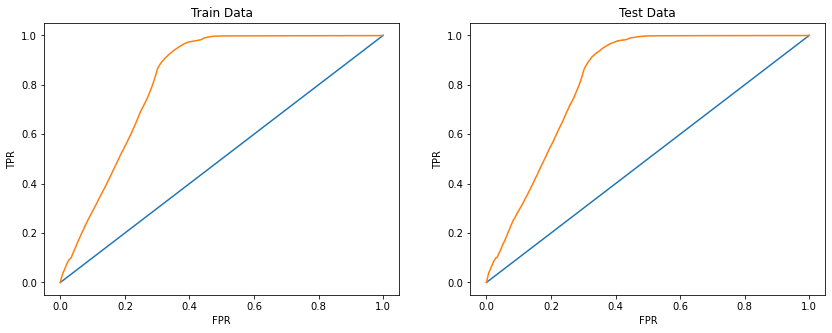

In [85]:
nb = GaussianNB()
nb.fit(X_train_sm, y_train_sm)
    
    #train datset
y_train_sm_pred = nb.predict(X_train_sm)
y_train_sm_proba = nb.predict_proba(X_train_sm)[::, 1]
    
    #test datset
y_test_pred = nb.predict(X_test_sel)
y_test_proba = nb.predict_proba(X_test_sel)[::, 1]

fpr_train,tpr_train,threshold_train = roc_curve(y_train_sm,y_train_sm_proba )
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_test_proba )

print(' GaussianNB :')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,fpr_train)
plt.plot(fpr_train,tpr_train)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train Data')

plt.subplot(1,2,2)
plt.plot(fpr_test,fpr_test)
plt.plot(fpr_test,tpr_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test Data')
plt.show()

##### This model is better fit compared to other models

### Feature importance

In [170]:
imps = permutation_importance(gnb, X_test_sel, y_test)
print(imps.importances_mean)

[ 3.46427196e-02  6.30185905e-04 -6.50841998e-02 -9.62784021e-05
  9.13419459e-03  2.55575395e-04  3.49017960e-02  3.31022652e-03
 -6.35192382e-02]


In [173]:
features = list(X_test_sel.columns)

In [176]:
# Print the feature ranking
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_test_sel.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. Vehicle_Age_< 1 Year (0.034902)
2. Age (0.034643)
3. Policy_Sales_Channel (0.009134)
4. Vehicle_Age_> 2 Years (0.003310)
5. Driving_License (0.000630)
6. Gender_Male (0.000256)
7. Annual_Premium (-0.000096)
8. Vehicle_Damage_Yes (-0.063519)
9. Previously_Insured (-0.065084)


In [177]:
import matplotlib.pyplot as plt

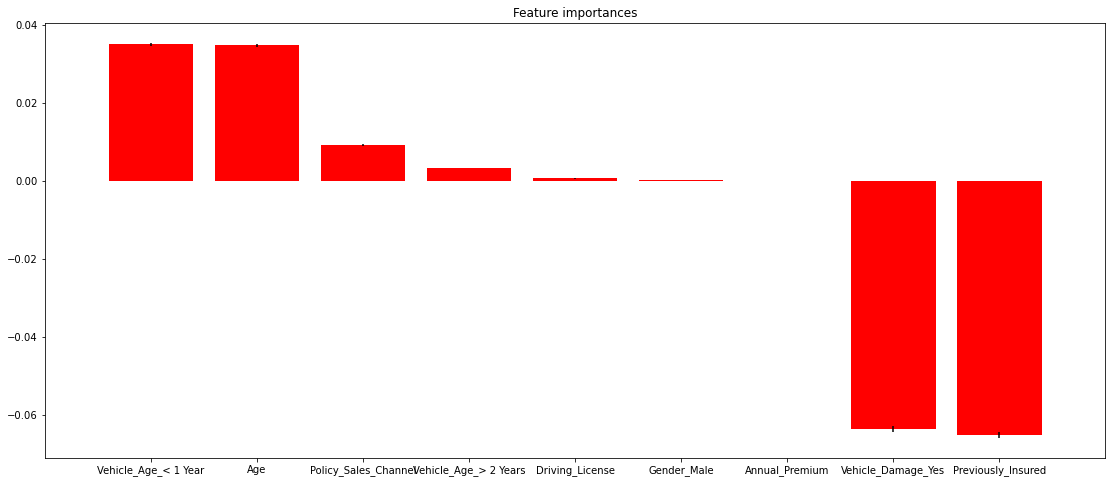

In [191]:
plt.figure(figsize=(19, 8))
plt.title("Feature importances")
plt.bar(range(X_test_sel.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test_sel.shape[1]), [features[indices[i]] for i in range(9)])
plt.xlim([-1, X_test_sel.shape[1]])
plt.show()

In [201]:
#If we remove the less important features, then recall and AUC_score will be reduced

#                                                     Thank you

In [203]:
from sklearn.model_selection import cross_val_score

In [206]:
gnb = GaussianNB()


(cross_val_score(gnb, X_train_sel, y_train, cv=10, n_jobs=1, scoring = 'roc_auc'))

array([0.82049832, 0.81712767, 0.82100735, 0.81562847, 0.81277062,
       0.81844751, 0.81693708, 0.81675701, 0.81369735, 0.81778103])

In [208]:
result_df.iloc[5]

Model_Name               GaussianNB
Accuracy_score_train       0.716705
roc_auc_score_train        0.817081
f1_score_train             0.430432
precision_score_train      0.285433
recall_score_train         0.874858
Accuracy_score_test         0.71541
roc_auc_score_test         0.817925
f1_score_test               0.43067
precision_score_test       0.285701
recall_score_test          0.874307
Name: 5, dtype: object

In [ ]:
X_